# Rossmann销售预测
Kaggle项目地址：https://www.kaggle.com/c/rossmann-store-sales

**环境要求：**
* Python 3.x
* Keras

## 1.数据分析

### 导入数据，用于数据分析

In [1]:
import visulization as vs
%matplotlib inline

data = vs.load_data()

print(data.head(3))

   Store       Date  Sales  Customers  Open  Promo StateHoliday  SchoolHoliday
0      1 2015-07-31   5263        555     1      1            0              1
1      2 2015-07-31   6064        625     1      1            0              1
2      3 2015-07-31   8314        821     1      1            0              1


### 可视化分析
#### 各个门店的年、月销售趋势可视化，随机选择动态的N个门店按月、按年显示

array([411, 406, 842, 560, 953])

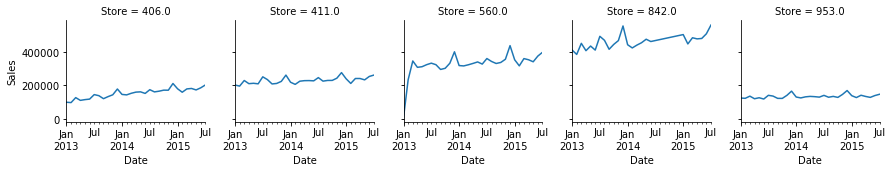

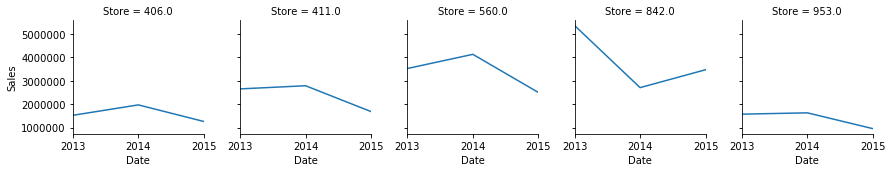

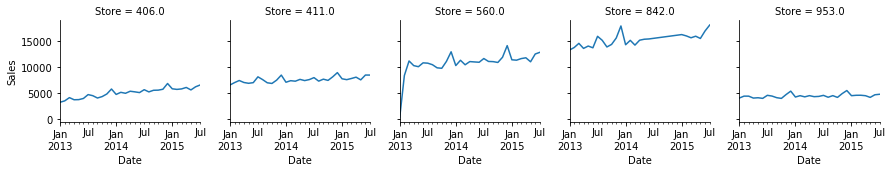

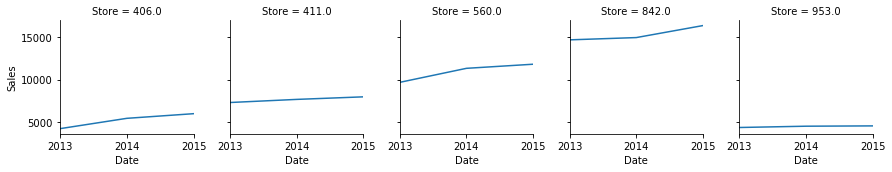

In [2]:
# Take 5 random stores to view the sales by dates, monthly & yearly view
# Monthly sum view
stores = vs.viewRandomStoreData(data,"M",'sum',size = 5)
# Yearly sum view
vs.viewStoreData(data,stores,"A",'sum')
# Monthly mean value view
vs.viewStoreData(data,stores, "M",'mean')
# Yearly mean value view
vs.viewStoreData(data,stores, "A",'mean')

### 可视化分析结论
从上面的图示可以得到一些分析结论：
* 不同门店差异较大，所以门店编号需要作为特征值训练模型

## 2.基准模型

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.stattools as st
import pyflux as pf


#daily_sales = pd.read_csv("./data/train.csv")
data = pd.DataFrame({'Sales':[100,222],'Date':['2017-08-20','2017-08-26'],'log':['',''],'Store':[1,2]})
# data['Sales'] = daily_sales['Sales']
# data['Date'] = daily_sales['Date']
# data['Store'] = daily_sales['Store']
# data = data[data.Store == 6]

data.sort_values("Date", ascending= True, inplace= True)
data.reset_index(inplace = True)

print(data.head(2))

max_log_y = np.max(np.log(data['Sales']))

def val_for_fit(val):
    val = np.log(val) / max_log_y
    return val

data['Sales'] = val_for_fit(data['Sales'])


print(data.head(2))



def test_stationarity(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    return dftest[1]


def best_diff(df, maxdiff = 8):
    p_set = {}
    for i in range(0, maxdiff):
        temp = df.copy() #每次循环前，重置
        if i == 0:
            temp['diff'] = temp[temp.columns[1]]
        else:
            temp['diff'] = temp[temp.columns[1]].diff(i)
            temp = temp.drop(temp.iloc[:i].index) #差分后，前几行的数据会变成nan，所以删掉
        pvalue = test_stationarity(temp['diff'])
        p_set[i] = pvalue
        p_df = pd.DataFrame.from_dict(p_set, orient="index")
        p_df.columns = ['p_value']
    i = 0
    while i < len(p_df):
        if p_df['p_value'][i]<0.01:
            bestdiff = i
            break
        i += 1
    return bestdiff


def produce_diffed_timeseries(df, diffn):
    if diffn != 0:
        df['diff'] = df[df.columns[1]].apply(lambda x:float(x)).diff(diffn)
    else:
        df['diff'] = df[df.columns[1]].apply(lambda x:float(x))
    df.dropna(inplace=True) #差分之后的nan去掉
    return df


def choose_order(ts, maxar, maxma):
    order = st.arma_order_select_ic(ts, maxar, maxma, ic=['aic', 'bic', 'hqic'])
    return order.bic_min_order


def predict_recover(ts, df, diffn):
    if diffn != 0:
        ts.iloc[0] = ts.iloc[0] + df['log'][-diffn]
        ts = ts.cumsum()
    ts = np.exp(ts)
#    ts.dropna(inplace=True)
    print('还原完成')
    return ts


# column 1 is datetime series
# column 0 is target value
def run_aram(df, maxar, maxma, test_size = 14):
    data = df.dropna()
    data['log'] = np.log(data[data.columns[0]])
    #    test_size = int(len(data) * 0.33)
    train_size = len(data)-int(test_size)
    train, test = data[:train_size], data[train_size:]
    if test_stationarity(train[train.columns[1]]) < 0.01:
        print('平稳，不需要差分')
    else:
        diffn = best_diff(train, maxdiff = 8)
        train = produce_diffed_timeseries(train, diffn)
        print('差分阶数为'+str(diffn)+'，已完成差分')
    print('开始进行ARMA拟合')
    order = choose_ order(train[train.columns[2]], maxar, maxma)
    print('模型的阶数为：'+str(order))
    _ar = order[0]
    _ma = order[1]
    model = pf.ARIMA(data=train, ar=_ar, ma=_ma, target='diff', family=pf.Normal())
    model.fit("MLE")
    test = test['payment_times']
    test_predict = model.predict(int(test_size))
    test_predict = predict_recover(test_predict, train, diffn)
    RMSE = np.sqrt(((np.array(test_predict)-np.array(test))**2).sum()/test.size)
    print("测试集的RMSE为："+str(RMSE))
    
run_aram(data, 4, 2)

## 3.数据预处理
为训练模型做数据准备，包括数据加载，序列化，归并整理，排序，编码

In [1]:
import prepare_data as raw_data

# Load data from csv files, as dict format
raw_data.read_data_as_dicts()

Titles:
['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday']
3 samples:
[{'Store': '1115', 'DayOfWeek': '2', 'Date': '2013-01-01', 'Sales': '0', 'Customers': '0', 'Open': '0', 'Promo': '0', 'StateHoliday': 'a', 'SchoolHoliday': '1'}, {'Store': '1114', 'DayOfWeek': '2', 'Date': '2013-01-01', 'Sales': '0', 'Customers': '0', 'Open': '0', 'Promo': '0', 'StateHoliday': 'a', 'SchoolHoliday': '1'}, {'Store': '1113', 'DayOfWeek': '2', 'Date': '2013-01-01', 'Sales': '0', 'Customers': '0', 'Open': '0', 'Promo': '0', 'StateHoliday': 'a', 'SchoolHoliday': '1'}]

Titles:
['Store', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']
Titles:
['Store', 'State']
2 samples:
[{'Store': '1', 'StoreType': 'c', 'Assortment': 'a', 'CompetitionDistance': '1270', 'CompetitionOpenSinceMonth': '9', 'CompetitionOpenSinceYear': '2008', 'Promo2': '

In [2]:
# Prepare data for processing, including reformat, ordering, standanlize, encoding
(X,y) = raw_data.prepare_data_for_process()
print("prepare data complete")
#print(type(X))

Prepare data from processning
Number of train datapoints:  844338
46 41551
[  0 109   1   0   0   0   0   7] 5961
prepare data complete


## 4.Enbedding神经网络模型的建立和训练
本项目的核心部分，主要包括：
* 实现基于Keras的Embedding神经网络，根据数据特征构建网络。使用的相关指标：
 * 评估指标：MAE（平均绝对误差）
* 划分训练集、验证集和测试集。使用原训练集中的5%作为测试集，10%作为验证集，剩下的85%作为训练集。
* 在建立的模型上使用训练集，验证集训练模型
 * 对训练集的数据进行一定规模的“取样”，并执行多次训练

In [77]:
import numpy
# 导入神经网络实现
from network import Enbedding_Network

train_ratio = 0.85
validate_ratio = 0.1
test_ratio = 0.05

num_records = len(X)
train_size = int(train_ratio * num_records)
validate_size = int(validate_ratio * num_records)
test_size = int(test_ratio * num_records)

test_index = train_size + validate_size

X_train = X[:train_size]
X_val = X[train_size:test_index]
X_test = X[test_index:]
y_train = y[:train_size]
y_val = y[train_size:test_index]
y_test = y[test_index:]

def sample(X, y, n):
    '''random samples'''
    num_row = X.shape[0]
    indices = numpy.random.randint(num_row, size=n)
    return X[indices, :], y[indices]

models = []
sample_size = 100000
fit_epoch = 5

print("Build embedding network with Keras ...")
for i in range(3):
    X_train, y_train = sample(X_train, y_train, sample_size)  # take a random sample for training
    print("Number of samples used for training: " + str(y_train.shape[0]))
    model = Enbedding_Network(X_train, y_train, X_val, y_val, fit_epoch)
    model.fit_model(X_train, y_train, X_val, y_val)
    models.append(model)

# Save modle    
#with open('models.pickle', 'wb') as f:
#    pickle.dump(models, f)

Build embedding network with Keras ...
Number of samples used for training: 100000
Train on 100000 samples, validate on 84433 samples
Epoch 1/5
100000/100000 [==============================] - 24s - loss: 0.0182 - val_loss: 0.0126
Epoch 2/5
100000/100000 [==============================] - 24s - loss: 0.0104 - val_loss: 0.0121
Epoch 3/5
100000/100000 [==============================] - 26s - loss: 0.0096 - val_loss: 0.0117
Epoch 4/5
100000/100000 [==============================] - 24s - loss: 0.0090 - val_loss: 0.0130
Epoch 5/5
100000/100000 [==============================] - 24s - loss: 0.0086 - val_loss: 0.0112
 Error rate for validation dataset:  0.01122558055350s

Number of samples used for training: 100000
Train on 100000 samples, validate on 84433 samples
Epoch 1/5
100000/100000 [==============================] - 25s - loss: 0.0179 - val_loss: 0.0124
Epoch 2/5
100000/100000 [==============================] - 24s - loss: 0.0103 - val_loss: 0.0119
Epoch 3/5
100000/100000 [===========

## 5.模型预测及结果分析
在预先选定的测试集上，执行Keras模型的预测（predict），并将多个模型的平均值作为最终结果，同时计算出错误率。

In [78]:
# Evaluate model 
def test_models(models, X, y):
    assert(min(y) > 0)
    predict_sales = numpy.array([model.predict(X) for model in models])
    predicted_sales_mean = predict_sales.mean(axis=0)
    relative_err = numpy.absolute((y - predicted_sales_mean) / y)
    result = numpy.sum(relative_err) / len(y)
    return result,predicted_sales_mean

print("Testing error rate ...")
r_val,predicted_sales_mean = test_models(models, X_test, y_test)
print(r_val)

Testing error rate ...
0.106123066729


### 结果可视化对比
将在测试集的中随机选择这个商店，进行销售了（Sales）的可视化对比，从而直观了解预测的效果。整个过程包含以下几个步骤：
* 解码（LabelEncoder）测试集的数据，并格式化时间
* 构造相应的预测结果序列
* 随机从测试集中选择某个商店（view_store_id）来进行可视化
* 在同一个图上画出选定商店的实际和预测销售额

In [82]:
# 反序列化数据
import pickle 
import numpy as np
import pandas as pd

# Restore label encoder for decoding
encoders = []
with open('les.pickle', 'rb') as le:
    les = pickle.load(le)
    encoders = les

# Prepare labels dataframe
test_df = pd.DataFrame(X_test)
test_df.columns = ['store_open', 'store_index', 'day_of_week', 'promo',
                  'year','month','day','state'] 

for idx,value in enumerate(test_df.columns):
    test_df[value] = encoders[idx].inverse_transform(test_df[value])

test_df.drop(['store_open','day_of_week','promo','state'], axis = 1, inplace = True)
test_df['Date'] = pd.to_datetime(test_df[['year','month','day']])
test_df.drop(['year','month','day'], axis = 1, inplace = True)
test_df['Sales'] = pd.Series(y_test)    
# print(test_df.head(2))
# print(type(test_df['Date'][2]))
# print("")

# Prepare prediction dataframe
prd_df = pd.DataFrame({'Date':[],'Sales':[]})
prd_df['Date'] = test_df['Date']
prd_df['Sales'] = pd.Series(predicted_sales_mean)
# print(prd_df.head(2))
# print("")

# Prepare plot data
view_store_id = np.random.choice(len(test_df['store_index'].unique()),1)[0]
print("Picking Store {0} to plot:".format(str(view_store_id)))
plot_df = test_df[test_df.store_index == str(view_store_id)].copy()
plot_sales_df = prd_df.loc[plot_df.index]

plot_df.drop(['store_index'],axis = 1, inplace = True)
plot_df.set_index(['Date'], inplace=True)
plot_df.index.name=None
plot_sales_df.set_index(['Date'], inplace=True)
plot_sales_df.index.name=None

# print(plot_df.head(2))
# print(plot_sales_df.head(2))

print("done")

Picking Store 92 to plot:
done


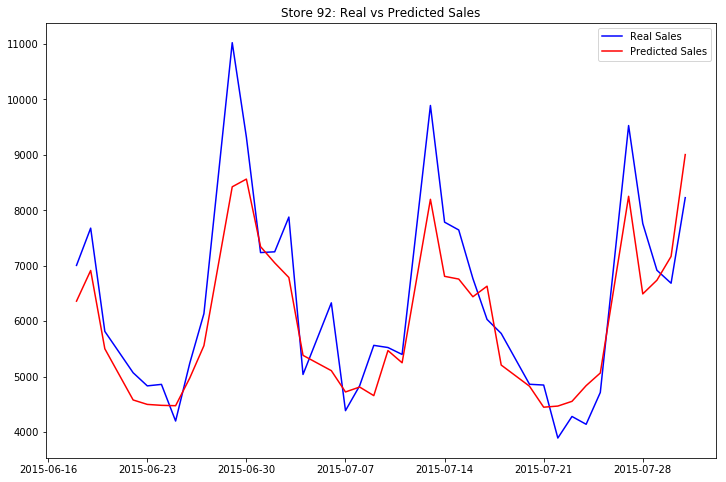

In [83]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 8))
orig = plt.plot(plot_df, color='blue', label='Real Sales')
predicted = plt.plot(plot_sales_df, color='red', label='Predicted Sales')
plt.legend(loc='best')
plt.title('Store {0}: Real vs Predicted Sales'.format(str(view_store_id)))
plt.show()

## 6. 预测效果及其实用性分析

## Reference
* PyFlux: http://www.pyflux.com/docs/getting_started.html         
* Entity Embeddings of Categorical Variables:https://arxiv.org/abs/1604.06737
* Keras: https://keras.io/models/about-keras-models/
* SARIMAX：http://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html